Proposed models:
- quadratic regression
- quadratic regression with weighted least squares
- quartic regression with fixing coefficients to have 0 at the boundary (doesn't address heteroskedacity): $(ax + bx^2)(cy + dy^2)$
- fit log(1 + std)

Do a 5-fold split with 5 generated dataframes, compute rmse for each model (new notebook).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

from utils import lev_sigma_mean_std

In [2]:
for i in range(1, 6):
    df = lev_sigma_mean_std()
    df.to_csv(f"output/lev_sigma_std_{i}.csv")

/home/roberto/Projects/Quant finance/Leveraged ETFs/utils.py:40: RuntimeWarning: invalid value encountered in log
  np.cumsum(np.log((np.exp(drift + diffusion) - 1) * leverage + 1), axis=1)


quadratic regression:

In [3]:
df = pd.read_csv("output/lev_sigma_std.csv")

In [4]:
# 1. Prepare your features (X) and target (y)
# df has columns ['leverage', 'sigma', 'std']
X = df[["leverage", "sigma"]]
z = df["std"]

# 2. Create a pipeline: Polynomial Expansion -> Linear Regression
model = Pipeline(
    [("poly", PolynomialFeatures(degree=2)), ("linear", LinearRegression())]
)

# 3. Fit the model
model.fit(X, z)

# 4. Predict values (e.g., to see how well it fits)
df["std_fitted"] = model.predict(X)

In [5]:
print(f"mse = {mean_squared_error(z,df["std_fitted"])}")

mse = 0.15140401951405275


In [6]:
z.var()

np.float64(1.8407259777869465)

In [7]:
model.score(X, z)

0.9177394336487592

transform by log(1+x)

In [8]:
df = pd.read_csv("output/lev_sigma_std.csv")

In [9]:
df["log1_std"] = np.log(1 + df["std"])

In [10]:
# plot

# reshape into matrix form
pivot = df.pivot(index="sigma", columns="leverage", values="log1_std")

X = pivot.columns.values  # leverage values
Y = pivot.index.values  # sigma values
Z = pivot.values  # std values

X, Y = np.meshgrid(X, Y)

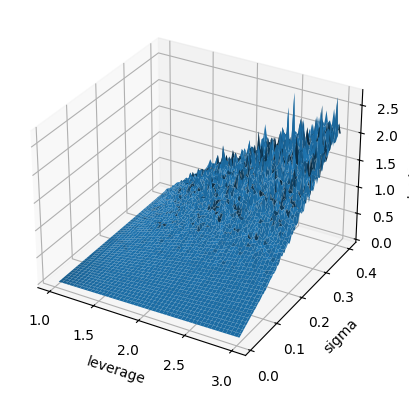

In [11]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")

ax.plot_surface(X, Y, Z)

ax.set_xlabel("leverage")
ax.set_ylabel("sigma")
ax.set_zlabel("log(1+std)")

plt.show()

In [12]:
# df has columns ['leverage', 'sigma', 'std']
X = df[["leverage", "sigma"]]
z = df["log1_std"]

# 2. Create a pipeline: Polynomial Expansion -> Linear Regression
model = Pipeline(
    [
        ("poly", PolynomialFeatures(degree=2)),
        ("linear", LinearRegression(fit_intercept=False)),
    ]
)

# 3. Fit the model
model.fit(X, z)

# 4. Predict values (e.g., to see how well it fits)
df["log1_std_fitted"] = model.predict(X)

In [13]:
print(f"mse = {mean_squared_error(z,df["log1_std_fitted"])}")

mse = 0.002764839715253381


In [14]:
# Access the coefficients
coefficients = model.named_steps["linear"].coef_
intercept = model.named_steps["linear"].intercept_

# Get the feature names in the correct order
feature_names = model.named_steps["poly"].get_feature_names_out()

# Display coefficients with their corresponding feature names
coef_df = pd.DataFrame({"Feature": feature_names, "Coefficient": coefficients})
print(coef_df)
print(f"Intercept: {intercept}")

          Feature  Coefficient
0               1     0.004227
1        leverage     0.093688
2           sigma    -4.071071
3      leverage^2    -0.040152
4  leverage sigma     2.822160
5         sigma^2     3.701167
Intercept: 0.0


In [15]:
z.var()  # baseline to compare mse to

np.float64(0.25208780164354816)

In [16]:
model.score(X, z)  # R2

0.9890311383222503

In [17]:
# compare on original scale

df["std_fitted"] = np.exp(df["log1_std_fitted"]) - 1

print("original-scale mse = ", mean_squared_error(df["std"], df["std_fitted"]))

r2_original_scale = (
    1
    - ((df["std"] - df["std_fitted"]) ** 2).sum()
    / ((df["std"] - df["std"].mean()) ** 2).sum()
)
print("original-scale R^2 = ", r2_original_scale)

original-scale mse =  0.07597835800655268
original-scale R^2 =  0.9587195717781043


Now address the growing residuals.

In [18]:
df["residual"] = df["std"] - df["std_fitted"]

In [19]:
# plot

# reshape into matrix form
pivot = df.pivot(index="sigma", columns="leverage", values="residual")

X = pivot.columns.values  # leverage values
Y = pivot.index.values  # sigma values
R = pivot.values  # residual values

X, Y = np.meshgrid(X, Y)

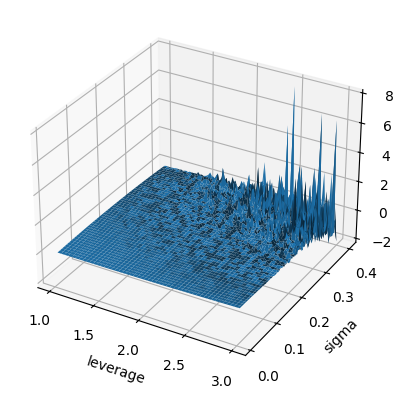

In [20]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")

ax.plot_surface(X, Y, R)

ax.set_xlabel("leverage")
ax.set_ylabel("sigma")
ax.set_zlabel("residuals")

plt.show()

In [21]:
df["residual_transformed"] = np.log(1 + (df["std"] - df["std_fitted"]) ** 2)

In [22]:
# reshape into matrix form
pivot = df.pivot(index="sigma", columns="leverage", values="residual_transformed")

X = pivot.columns.values  # leverage values
Y = pivot.index.values  # sigma values
R = pivot.values  # transformed residual values

X, Y = np.meshgrid(X, Y)

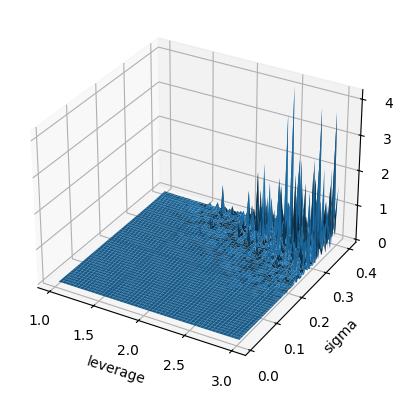

In [23]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")

ax.plot_surface(X, Y, R)

ax.set_xlabel("leverage")
ax.set_ylabel("sigma")
ax.set_zlabel("log(1+residual^2)")

plt.show()

Weighted least squares:

In [24]:
# Step 0: define weights as exponential in both inputs
# you can tune alpha and beta to match how fast residuals grow
alpha = 5  # coefficient for leverage
beta = 5  # coefficient for sigma

X = df[["leverage", "sigma"]]
z = df["log1_std"]

weights = 1 / np.exp(alpha * X["leverage"] + beta * X["sigma"])
# weights = 1/np.exp(np.exp(X["leverage"] + X["sigma"]))


# Step 1: create pipeline
model = Pipeline(
    [
        ("poly", PolynomialFeatures(degree=2)),
        ("linear", LinearRegression(fit_intercept=False)),
    ]
)

# Step 2: fit with WLS weights
model.fit(X, z, linear__sample_weight=weights)

# Step 3: predict
df["log1_std_fitted_wls"] = model.predict(X)

In [25]:
mean_squared_error(z, df["log1_std_fitted_wls"])

0.0040718782331068334

In [26]:
z.var()

np.float64(0.25208780164354816)

In [27]:
model.score(X, z)

0.9838457655027227

quartic regression (without restrictions):

In [28]:
df = pd.read_csv("output/lev_sigma_std.csv")

In [29]:
# 1. Prepare your features (X) and target (y)
# df has columns ['leverage', 'sigma', 'std']
X = df[["leverage", "sigma"]]
z = df["std"]

# 2. Create a pipeline: Polynomial Expansion -> Linear Regression
model = Pipeline(
    [
        ("poly", PolynomialFeatures(degree=4)),
        ("linear", LinearRegression(fit_intercept=False)),
    ]
)

# 3. Fit the model
model.fit(X, z)

# 4. Predict values (e.g., to see how well it fits)
df["std_fitted"] = model.predict(X)

In [30]:
print(f"mse = {mean_squared_error(z,df["std_fitted"])}")

mse = 0.07314476340544722


In [31]:
z.var()

np.float64(1.8407259777869465)

In [32]:
model.score(X, z)

0.9602591154272417

quartic regression with log(1+x) pre-transformation:

In [33]:
df = pd.read_csv("output/lev_sigma_std.csv")
df["log1_std"] = np.log(1 + df["std"])

In [34]:
# df has columns ['leverage', 'sigma', 'std']
X = df[["leverage", "sigma"]]
z = df["log1_std"]

# 2. Create a pipeline: Polynomial Expansion -> Linear Regression
model = Pipeline(
    [
        ("poly", PolynomialFeatures(degree=4)),
        ("linear", LinearRegression(fit_intercept=False)),
    ]
)

# 3. Fit the model
model.fit(X, z)

# 4. Predict values (e.g., to see how well it fits)
df["log1_std_fitted"] = model.predict(X)

In [35]:
print(f"mse = {mean_squared_error(z,df["log1_std_fitted"])}")
print(z.var())
print(model.score(X, z))

mse = 0.002298775249226592
0.25208780164354816
0.9908801412255863


In [36]:
# see the coefficients

coefficients = model.named_steps["linear"].coef_
intercept = model.named_steps["linear"].intercept_

# Get the feature names in the correct order
feature_names = model.named_steps["poly"].get_feature_names_out()

# Display coefficients with their corresponding feature names
coef_df = pd.DataFrame({"Feature": feature_names, "Coefficient": coefficients})
print(coef_df)
print(f"Intercept: {intercept}")

               Feature  Coefficient
0                    1    -0.159461
1             leverage     0.208823
2                sigma     0.363355
3           leverage^2    -0.100973
4       leverage sigma     0.220392
5              sigma^2   -16.286114
6           leverage^3     0.024952
7     leverage^2 sigma     0.247359
8     leverage sigma^2    11.469278
9              sigma^3    21.686642
10          leverage^4    -0.002833
11    leverage^3 sigma     0.024884
12  leverage^2 sigma^2    -1.817153
13    leverage sigma^3    -2.813245
14             sigma^4   -17.380326
Intercept: 0.0


In [37]:
# compare on original scale

df["std_fitted"] = np.exp(df["log1_std_fitted"]) - 1

print("original-scale mse = ", mean_squared_error(df["std"], df["std_fitted"]))

r2_original_scale = (
    1
    - ((df["std"] - df["std_fitted"]) ** 2).sum()
    / ((df["std"] - df["std"].mean()) ** 2).sum()
)
print("original-scale R^2 = ", r2_original_scale)

original-scale mse =  0.0732803663369421
original-scale R^2 =  0.9601854398803213


Now create a consolidated procedure for outputting mse and r2:

In [38]:
dfs = [pd.read_csv(f"output/lev_sigma_std_{i}.csv") for i in range(1, 6)]

In [39]:
# now make general function, input is degree of polynomial, and boolean whether to preprocess with log(1+x) or not. include graphing of residuals and original

In [ ]:
def model_evaluate(df, degree=2, take_log=False, plot=False):

    def plot_surface():

        df_copy = df.copy()
        df_copy["z"] = z
        df_copy["z_hat"] = z_hat

        # reshape into matrix form
        pivot_org = df_copy.pivot(index="sigma", columns="leverage", values="z")
        pivot_hat = df_copy.pivot(index="sigma", columns="leverage", values="z_hat")

        X = pivot.columns.values  # leverage values
        Y = pivot.index.values  # sigma values
        Z_org = pivot_org.values  # original std values
        Z_hat = pivot_hat.values  # fitted std values

        X, Y = np.meshgrid(X, Y)

        fig = plt.figure(figsize=(8, 6))
        plt.tight_layout()
        ax = fig.add_subplot(projection="3d")

        ax.plot_surface(X, Y, Z_org, alpha=0.6)
        ax.plot_wireframe(X, Y, Z_hat)

        ax.set_xlabel("leverage")
        ax.set_ylabel("sigma")
        ax.set_zlabel("std")
        plt.title("mesh grid is the fitted values")

        plt.show()

    X = df[["leverage", "sigma"]]
    
    z = df["std"]
    transformer.transform(z)
    z = np.log(1 + df["std"]) if take_log else df["std"]

    model = Pipeline(
        [
            ("poly", PolynomialFeatures(degree=degree)),
            ("linear", LinearRegression(fit_intercept=False)),
        ]
    )

    model.fit(X, z)

    z_hat = model.predict(X)

    if take_log:
        z_hat = np.exp(z_hat) - 1

    mse = mean_squared_error(df["std"], z_hat)
    print("original-scale" if take_log else "", "mse = ", mse)

    r2 = (
        1
        - ((df["std"] - z_hat) ** 2).sum() / ((df["std"] - df["std"].mean()) ** 2).sum()
    )

    print("original-scale" if take_log else "", "R^2 = ", r2)

    if plot:
        plot_surface()

    return mse, r2

In [41]:
df = pd.read_csv("output/lev_sigma_std_1.csv")

 mse =  0.07550188469881451
 R^2 =  0.9598816827998071


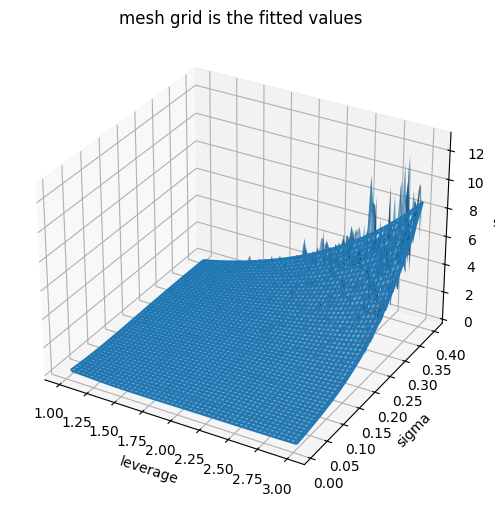

(0.07550188469881451, np.float64(0.9598816827998071))

In [42]:
model_evaluate(df, degree=4, take_log=False, plot=True)